In [1906]:
# %pip install qubovert
# %pip install qiskit
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install networkx
# %pip install pillow
# %pip install dwave-system

In [1907]:
from qubovert import boolean_var, QUBO
import pandas as pd
from qubovert.sim import anneal_qubo
import numpy as np
import re
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider
from qiskit.quantum_info import Statevector
from qiskit.circuit.quantumcircuit import QuantumCircuit as QCtype
from itertools import product
from qiskit import transpile
import numpy as np
import os
from qiskit.circuit.library import XGate, IGate, RZGate, SXGate, CXGate, U3Gate, ZGate, HGate, TGate, TdgGate, SGate, CCXGate, RXGate, Reset
# import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import networkx as nx
from PIL import Image, ImageDraw, ImageFont
import math

from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.system import LeapHybridSampler

### Creating the quantum circuit to optimize

Quantum circuit (qc) with 5 qubits
and apply cnot gates as in Fig.2 of the paper

In [1908]:
qc2 = QuantumCircuit(5)
qc2.cx(0,2)
# qc2.x(1)
qc2.cx(1,3)
qc2.cx(0,1)
qc2.cx(3,4)
qc2.cx(1,3)
qc2.cx(0,3)
qc2.cx(1,4)
qc2.cx(1,3)
qc2.cx(2,4)

qc2.draw()

### Gate class

The `Gate` class is used to store information about
the gates such as the name of the gate, the qiskit
function that implements it and the qubits it operates on

In [1909]:
class Gate:
    convertions = {
        'cx': CXGate,
        'x': XGate
    }
    def __init__(self, name:str, qubits:list, params:list=None):
        self.name = name
        self.qubits = qubits
        self.params = params
        try:
            self.func = self.convertions[name]
        except KeyError:
            raise Exception("This gate is not supported") from None
            
    def __repr__(self):
        s = f"(Gate: name: {self.name}, qubits: {self.qubits}"
        if self.params:
            s += f", Params: {self.params}"

        s += ")"
        return s


def get_qubits_idxs(qubits:list)->list[int]:
    '''Given a list of qubits, it returns a list of their indexes''' 
    idxs = []
    for q in qubits:
        idxs.append(q._index)

    return idxs


### Iterating over gates in a qiskit ciruit

We can iterate over the gates in a circuit in this way

The problem is that the informations are not easy to use (see below)

In [1910]:
for node_index in qc2.data:
    print(node_index)

So we can use the class we defined before and the 
`get_qubits_idxs()` function to make them nicer to
work with

In [1911]:

def get_gates_from_circuit(qc) -> list[Gate]:
    '''Given a QuantumCircuit, it returns a list of Gates'''
    gate_list = []
    # Iterate over all the gates in the qc
    for i in qc.data:
        op = i.operation.name
        qubits = i.qubits
        params = i.operation.params
        # Convert the qubits to a list of indexes
        qubits_indexes = get_qubits_idxs(qubits)

        # Add to the end of the gate_list the Gate
        gate_list.append(Gate(op, qubits_indexes, params))
    return gate_list

gate_list = get_gates_from_circuit(qc2)
for g in gate_list:
    print(g)
    

### Time slices

Time slices are basically a list of gates but it is convenient to make a class
that represents a time slice so that we can use them more easily (for example with the function
`contains_any` we can see if any qubit in a list is already present in the time slice).

For each time slice we get also get the laplacian matrix of the graph.

In [1912]:
# The TimeSlice class is a fancy list of gates
class TimeSlice:
    def __init__(self, idx, num_qubits=5):
        self.idx = idx
        self.num_qubits = num_qubits
        self.gates:list[Gate] = []
        # involved_qubits stores the qubits already involved in the slice
        # it is useful while performing slicing
        self.involved_qubits = []
        self.qubit_connections = [] # list of the connections between the qubits inside this time slice e.g. [(0,1), (3,4)]
        self.graph = nx.Graph() # graph of interaction of the qubits

    def append(self, gate:Gate):
        '''Adds the gate to the timeSlice making sure that the qubits are valid qubits'''
        # check if the gate we want to add to the slice
        # operates on the correct qubits
        for i in gate.qubits:
            if i >= self.num_qubits:
                raise(f"The TimeSlice has {self.num_qubits} but a gate acting on qubit {i} was added")
            if i in self.involved_qubits:
                raise(f"Error: qubit {i} is already present in TimeSlice{self.idx}")

            self.involved_qubits.append(i)
        
        # create the graph of the interactions of the qubits involved in the same gate
        for l in list(itertools.combinations(gate.qubits, 2)):
            self.qubit_connections.append(l) ## ATTENZIONE: nel paper non tutti i qubit coinvolti in un gate sono connessi tra di loro
        
        # add nodes (qubits) to the graph
        self.graph.add_nodes_from(gate.qubits)

        # add edges to the graph
        self.graph.add_edges_from(self.qubit_connections)
            
        self.gates.append(gate)

    @property
    def laplacian(self):
        '''Laplacian matrix of the graph
        taking into account also qubits that are not present in the slice
        (i.e. the ones that generate columns of all zeroes)'''

        G = nx.Graph()
        G.add_nodes_from(range(self.num_qubits))
        G.add_edges_from(self.qubit_connections)
        # fig, axs = plt.subplots(1, 1, figsize=(2 * 1, 2))
        # pos = nx.shell_layout(G, scale=0.4, rotate=0)  # Posizioni dei nodi
        # nx.draw(G, pos, ax=axs, with_labels=True, node_size=300, node_color='red', font_size=10, font_color='black')
        return nx.laplacian_matrix(G).todense()

    def contains_any(self, qubits: list):
        '''Returns true if at least one of the qubits is already used in the timeSlice'''
        return True if [i for i in qubits if i in self.involved_qubits] else False

    def show(self):
# Crea una figura con un numero di sottofigure adeguato
        fig, axs = plt.subplots(1, 1, figsize=(2 * 1, 2))
        pos = nx.shell_layout(self.graph, scale=0.4, rotate=0)  # Posizioni dei nodi
        nx.draw(self.graph, pos, ax=axs, with_labels=True, node_size=300, node_color='lightblue', font_size=10, font_color='black')
        print(self.laplacian)
    @property
    def quantum_circuit(self) -> QCtype:
        qc = QuantumCircuit(self.num_qubits)
        for gate in self.gates:
            qc.compose(gate.func(*gate.params), gate.qubits, inplace=True)
        return qc

    def __repr__(self):
        s = f"(TimeSlice{self.idx}, gates: {self.gates}, edges: {self.qubit_connections})"
        return s

### Slicing the circuit

We can now slice the circuit loosely following algorithm 1 of the paper

In [1945]:

def slice_circuit(qc, num_qubits) -> list[TimeSlice]:
    '''Applies the ADDGATE funciton of the 
    paper (Algorithm 1) to the QuantumCircuit qc'''
    gate_list = get_gates_from_circuit(qc)
    # Create an empty list of slices
    slices:TimeSlice= []
    for g in gate_list:
        # "if gate in slices[t]" <- this check should not be needed

        # if this is the first slice we simply add the qubit
        if len(slices) == 0:
            slices.append(TimeSlice(len(slices), num_qubits=num_qubits))
            slices[0].append(g) # given a list l, l[-1] is the last element of the list

        # check if any qubit is already involved in the current time slice
        elif slices[-1].contains_any(g.qubits):
            # if it is we have to create a new slice and add the qubit to it
            slices.append(TimeSlice(len(slices), num_qubits=num_qubits))
            slices[-1].append(g)
        else:
            slices[-1].append(g)

    return slices


In [1946]:
list_of_slices = slice_circuit(qc2, 5)
for node_index in list_of_slices:
    print(node_index)

In [1947]:
list_of_slices[0].show()
list_of_slices[0].quantum_circuit.draw()

In [1948]:
def circuit_from_slices(slices:list[TimeSlice], num_qubits):
    '''Given a list of TimeSlices and the number of qubits of the
    final circuit, it returns the circuit with barriers separating
    different time slices'''
    qc = QuantumCircuit(num_qubits)
    for slice in slices:
        qc.compose(slice.quantum_circuit, inplace=True)
        qc.barrier()
    return qc

qc2_sliced = circuit_from_slices(list_of_slices, 5)
qc2_sliced.draw()


In [1949]:
def draw_graphs(list_of_edges):
    '''Function to plot a graph of connected nodes'''
    # Calcola il numero di sottofigure necessarie
    num_subfigures = len(list_of_edges)
    
    # Crea una figura con un numero di sottofigure adeguato
    fig, axs = plt.subplots(1, num_subfigures, figsize=(2.5 * num_subfigures, 2.5))
    
    # Se c'è solo una sottofigura, axs non è una lista, quindi lo rendiamo una lista
    if num_subfigures == 1:
        axs = [axs]
    
    for i, edges in enumerate(list_of_edges):
        # Crea un grafo non orientato
        G = nx.Graph()
        
        # Aggiungi gli archi al grafo
        G.add_edges_from(edges)
        
        # Disegna il grafo nella sottofigura corrispondente
        pos = nx.shell_layout(G, scale=0.4, rotate=0)  # Posizioni dei nodi
        nx.draw(G, pos, ax=axs[i], with_labels=True, node_size=300, node_color='lightblue', font_size=10, font_color='black')
        
        # Imposta il titolo della sottofigura
        axs[i].set_title(f'Graph {i}')
    
    # Mostra la figura
    plt.tight_layout()
    plt.show()



In [1950]:
class MultiCoreMapper:
    def __init__(self, qc:QCtype, num_cores:int, cores_capacities:list[int], lamb=0.1):
        self.num_cores = num_cores
        self.cores_capacities = cores_capacities
        self.qc = qc
        self.lamb = lamb
        # print(qc.num_qubits)
        self.num_qubits = qc.num_qubits
        self.slices: list[TimeSlice] = slice_circuit(qc, self.num_qubits)

        self.x = self.create_x()
        self.y = self.create_y()

        self.solution = None
        self.solution_graphs = None

    def create_x(self):
        '''Returns the X data structure of binary variables'''
        # [x0, x1, x2, x3, ...]
        x = []
        for t in range(len(self.slices)):
            l2 = []
            for j in range(self.num_cores):
                l1 = []
                for i in range(self.num_qubits):
                    bv = boolean_var(f"x_{t}_{j}_{i}")
                    l1.append(np.atleast_1d(bv))
                l2.append(np.asarray(l1))
            x.append(l2)
        return x
    
    def create_y(self):
        '''Returns the Y data structure of binary variables representing the auxialiry variables'''
        y = []
        for t in range(len(self.slices)):
            l2 = []
            for j in range(self.num_cores):
                l1 = []
                for i in range(self.cores_capacities[j]):
                    bv = boolean_var(f"y_{t}_{j}_{i}")
                    l1.append(bv)
                l2.append(np.asarray(l1))
            y.append(l2)
        return y
    
    def optimize(self, solver, num_anneals=1):
        if solver == anneal_qubo:
            solution = anneal_qubo(self.H,  num_anneals=num_anneals)
            self.solution = solution.best.state
        elif solver == SimulatedAnnealingSampler:
            self.solution = SimulatedAnnealingSampler().sample_qubo(self.H.Q).first.sample
        elif solver == EmbeddingComposite:
            solver = EmbeddingComposite(DWaveSampler(token="DEV-e5eba9b7fc9a887f8a8b517118b5f56da1d3f874"))
            response = solver.sample_qubo(self.H.Q, label='multicore')  
            QpuAccessTime = response.info['timing']['qpu_access_time']
            print(f"QPU access time: {QpuAccessTime}")
            self.solution = response.first.sample  
        return self.solution


$$
R({\bf x}^{t}):=\sum_{j=1}^{k}\left(\sum_{i=1}^{n}x_{i j}^{t}-\sum_{i^{\prime}=1}^{c_{j}}y_{i^{\prime}j}^{t}\right)^{2}
$$

In [1951]:
# This is the same as writing the Rxt function inside the class in the cell above but in this way
# we can put some markdown before the cell to make it easier to read
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Rxt(self) -> list[QUBO]:
        Rxt_list = []

        for t, l2 in enumerate(self.x):
            s_tot = QUBO()
            for j, l1 in enumerate(self.x[t]):
                # print(f"j = {j}")
                s1 = QUBO()
                for i, _ in enumerate(self.x[t][j]):
                    # print(f"i = {i}")
                    s1 += self.x[t][j][i].item()
                    # print(stemp)

                # print(s1)
                s2 = QUBO()
                for i_prime in range(self.cores_capacities[j]):
                    # print(f"i_prime = {i_prime}")
                    # print(stemp)
                    s2 += self.y[t][j][i_prime]
                s_12 = (s1 - s2)**2
                s_tot += s_12 # s_tot = s_tot + s_12
            Rxt_list.append(s_tot)
        return Rxt_list
   

$$
S({\bf x}^{t}):=\sum_{i=1}^{n}\left(\sum_{j=1}^{k}x_{i j}^{t}-1\right)^{2}
$$

In [1952]:
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Sxt(self) -> list[QUBO]:
        Sxt_list = []
        for t, l2 in enumerate(self.x):
            s_tot = QUBO()
            for i in range(self.num_qubits):
                s1 = QUBO()
                for j in range(self.num_cores):
                    s1 += self.x[t][j][i].item()
                s_tot += (s1 - 1)**2
                # print((s1 - 1)**2)
                # print("\n\n")
            # print(s_tot)
            # print("\n\n")
            Sxt_list.append(s_tot)
        return Sxt_list


$$ P({\bf x}^{t}):=\sum_{j=1}^{k}{\bf x}_{j}^{t T}L_{t}{\bf x}_{j}^{t} $$

In [1953]:
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Pxt(self) -> list[QUBO]:
        Pxt_list = []
        qctest = QuantumCircuit(self.num_qubits)
        qctest.cx(0,2)
        # qctest.cx(1,2)
        qctest.cx(0,1)
        # qctest.draw()
        for t, l2 in enumerate(self.x):
            s_tot = QUBO()
            for j in range(self.num_cores):
                prod1 = np.dot( self.x[t][j].T, self.slices[t].laplacian)
                s_tot += np.dot(prod1, self.x[t][j]).item()
            # print(s_tot)
            # print()
            Pxt_list.append(s_tot)
        return Pxt_list

$$d({\bf x}^{t-1},{\bf x}^{t}):=\sum_{i=1}^{n}d_{j l}x_{i j}^{t-1}x_{i l}^{t}$$

In [1954]:
class MultiCoreMapper(MultiCoreMapper):
    @property
    def dxt(self) -> list[QUBO]:
        dxt_list = []
        for t in range(len(self.x)):
            if t == 0:
                continue
            d_tot = QUBO()
            for i in range(self.num_qubits):
                for j in range(self.num_cores):
                    for l in range(self.num_cores):
                        if j == l:
                            dij = 0
                        else:
                            dij = 1
                        d_tot += (dij * self.x[t-1][j][i] * self.x[t][l][i]).item()

            dxt_list.append(d_tot)
        return dxt_list


$$\operatorname*{min}_{{\bf x}}H_{t}({\bf x})=\operatorname*{min}_{{\bf x}}\sum_{t=2}^{T}d({\bf x}^{t-1},{\bf x}^{t})$$

In [1955]:
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Htx(self) -> QUBO:
        Htx_sum = QUBO()
        for d in self.dxt:
            Htx_sum += d
        
        return Htx_sum

$$\operatorname*{min}_{{\bf x}^{t}}\,F({\bf x}^{t})=\operatorname*{min}_{{\bf x}^{t}}\,S({\bf x}^{t})+P({\bf x}^{t})+R({\bf x}^{t})$$

$$\operatorname*{min}_{\mathbf{x}}H_{a}(\mathbf{x})=\operatorname*{min}_{\mathbf{x}}\sum_{t=1}^{T}F(\mathbf{x}^{t})$$

In [1956]:
class MultiCoreMapper(MultiCoreMapper):
    @property
    def Hax(self) -> QUBO:
        Hax_sum = QUBO()
        for t in range(len(self.x)):
            Hax_sum += self.Sxt[t] + self.Pxt[t] + self.Rxt[t]
        
        return Hax_sum

$$\operatorname*{min}_{\mathbf{x}}H(\mathbf{x},\lambda)=\operatorname*{min}_{\mathbf{x}}\left[H_{a}(\mathbf{x})+\lambda\cdot H_{t}(\mathbf{x})\right]$$

In [1957]:
class MultiCoreMapper(MultiCoreMapper):
    @property
    def H(self) -> QUBO:
        H_sum = QUBO()
        H_sum = self.Hax + self.lamb * self.Htx 
        
        return H_sum

In [1926]:
class SolutionDrawer:
    def __init__(self, mcm:MultiCoreMapper, image_width = 1200, image_height = 400):
        self.mcm = mcm
        self.image_width = image_width
        self.image_height = image_height
        self.image = Image.new('RGB', (image_width, image_height), 'white')
        self.draw = ImageDraw.Draw(self.image)
        self.num_rectangles = len(self.mcm.x)
        self.rect_width = image_width // self.num_rectangles - 20
        self.rect_height = image_height - 20
        self.num_nodes  = self.mcm.num_qubits
        self.all_circle_positions = [[None for j in range(self.num_nodes)] for i in range(self.num_rectangles)]
        self.circle_radius=20
        self.font = ImageFont.load_default(size=20)

    def _get_rect_coords(self, rect_index):
        # Coordinate del rettangolo
        rect_x0 = 10 + rect_index * (self.rect_width + 10)
        rect_y0 = 10
        rect_x1 = rect_x0 + self.rect_width
        rect_y1 = rect_y0 + self.rect_height
        return rect_x0, rect_y0, rect_x1, rect_y1

    def _draw_rect(self, rect_index):
        rect_x0, rect_y0, rect_x1, rect_y1 = self._get_rect_coords(rect_index)

        # Disegno del rettangolo
        self.draw.rectangle([rect_x0, rect_y0, rect_x1, rect_y1], outline='black', width=3)

    def _draw_node(self, node_index, rect_index, color, core=None, fill=None):
        rect_x0, rect_y0, rect_x1, rect_y1 = self._get_rect_coords(rect_index)
        # Calcolo delle posizioni dei cerchi in modo circolare
        center_x = (rect_x0 + rect_x1) / 2
        center_y = (rect_y0 + rect_y1) / 2
        radius = min(rect_x1 - rect_x0, rect_y1 - rect_y0) / 3
        angle = 2 * math.pi * node_index / self.num_nodes
        circle_x = center_x + radius * math.cos(angle)
        circle_y = center_y + radius * math.sin(angle)
        circle_positions = (circle_x, circle_y)

        # Coordinate del cerchio
        circle_x0 = circle_x - self.circle_radius
        circle_y0 = circle_y - self.circle_radius
        circle_x1 = circle_x + self.circle_radius
        circle_y1 = circle_y + self.circle_radius

        anchor = "rt"
        # the node has already been drawn
        if self.all_circle_positions[rect_index][node_index]:
            fill = "red" 
            anchor = "ld"

        # Disegno del cerchio
        self.draw.ellipse([circle_x0, circle_y0, circle_x1, circle_y1], outline=color, fill=fill, width=3)
        self.draw.text((circle_x, circle_y), text=str(node_index), font=self.font, fill="black", align="center", anchor="mm")
        # print(f"core: {core}, node: {node_index}, rect: {rect_index}")
        if core is not None:
            # print(core)
            self.draw.text((circle_x1, circle_y1), text=str(core), font=self.font, fill=color, align="center", anchor=anchor, font_size=6)

        self.all_circle_positions[rect_index][node_index]  = circle_positions

    def _draw_edge(self, nodes, rectangles, color):
        def get_edge_point(x1, y1, x2, y2, radius):
            angle = math.atan2(y2 - y1, x2 - x1)
            return x1 + radius * math.cos(angle), y1 + radius * math.sin(angle)
        
        pos1 = self.all_circle_positions[rectangles[0]][nodes[0]]
        pos2 = self.all_circle_positions[rectangles[1]][nodes[1]]
        if pos1 is None:
            self._draw_node(nodes[0], rectangles[0], "black", fill="gray")
        if pos2 is None:
            self._draw_node(nodes[1], rectangles[1], "black", fill="gray")
        
        pos1 = self.all_circle_positions[rectangles[0]][nodes[0]]
        pos2 = self.all_circle_positions[rectangles[1]][nodes[1]]

        x1, y1 = pos1
        x2, y2 = pos2
        edge_x1, edge_y1 = get_edge_point(x1, y1, x2, y2, self.circle_radius)
        edge_x2, edge_y2 = get_edge_point(x2, y2, x1, y1, self.circle_radius)
        self.draw.line([edge_x1, edge_y1, edge_x2, edge_y2], fill=color)

    def draw_solution(self):
        assert self.mcm.solution is not None, "MulticoreMapper has no solution, have you run the optimization?"
        state = self.mcm.solution
        num_slices = len(self.mcm.x)
        num_cores = self.mcm.num_cores
        self.solution_graphs = [[[],[]] for i in range(num_slices)]
        # print(solution_graphs)
        for var in state:
            if state[var] == 0:
                continue
            
            # get the name ('y' or 'x'), time slice, core and qubit
            name, t, c, q = var.split('_')
            if name == 'y':
                continue
            t, c, q = map(int, [t, c, q])
            self.solution_graphs[t][c].append(q)
        # print('#'*10)
        colors = ["green", "blue", "yellow", "purple", "orange", "brown"]
        for t, slice in enumerate(self.solution_graphs):
            self._draw_rect(t)
            for k, core in enumerate(slice):
                for qubit in core:
                    self._draw_node(qubit, t, colors[k], k)
            # Add intra-slice connections
            for nodes in self.mcm.slices[t].qubit_connections:
                # print(nodes)
                self._draw_edge(nodes, [t,t], "black")

        # Add inter-slice edges to show qubits that changed core
        for t, slice in enumerate(self.solution_graphs):
            for k, core in enumerate(slice):
                for qubit in core:
                    done = False
                    for t_follow_int, slice_follow in enumerate(self.solution_graphs[t+1:]):
                        t_follow = t + t_follow_int + 1
                        # print(t == t_follow)
                        for k_follow, core_follow in enumerate(slice_follow):
                            if qubit in core_follow:
                                done = True
                                if k != k_follow:
                                    # print(f"k: {k}, k_follow: {k_follow}, qubit: {qubit}, t: {t}, t_follow: {t_follow}")
                                    self._draw_edge((qubit, qubit), (t, t_follow), "red")

                        if done:
                            break


        self.image.show()

In [1927]:
mcm = MultiCoreMapper(qc2, 2, [4,4])

In [ ]:
drawer = SolutionDrawer(mcm)
sol = mcm.optimize(EmbeddingComposite, num_anneals=1000)
drawer.draw_solution()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f766dbeb670>>
Traceback (most recent call last):
  File "/home/gambero/qubito-hackaton-int-1/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


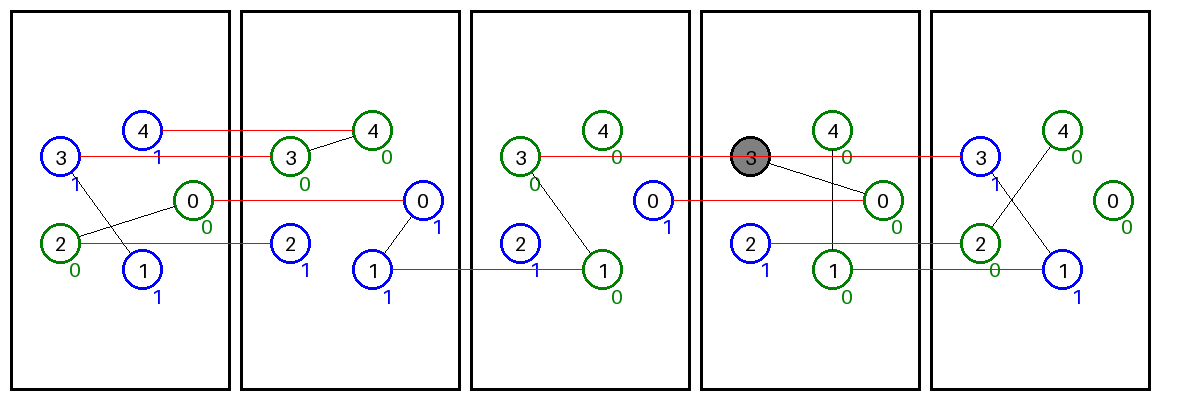

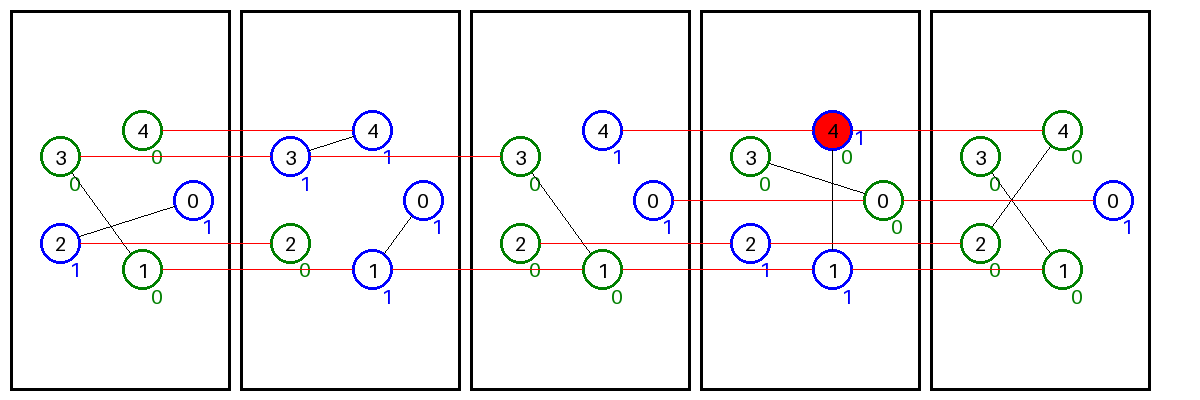

![image.png](attachment:image.png)